# CNN Training
We will train a sample CNN using the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html).

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import random
import pickle
import matplotlib.pyplot as plt

In [2]:
# Downloading the dataset
!mkdir CIFAR-10
%cd CIFAR-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..

mkdir: CIFAR-10: File exists
/Users/ryoandrewonozuka/Documents/Coding/GitHub/UCSD/CSE 152A/Discussions/CIFAR-10
--2024-06-04 03:56:37--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.


/Users/ryoandrewonozuka/Library/Python/3.10/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar  37%[======>             ]  60.54M   430KB/s    eta 54s    ^C
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4: truncated gzip input
tar: Error exit delayed from previous errors.
/Users/ryoandrewonozuka/Documents/Coding/GitHub/UCSD/CSE 152A/Discussions


In [ ]:
# DATA PARSING
path='./CIFAR-10/cifar-10-batches-py/'
data=np.zeros((0,32,32,3))
labels=[]
for i in range(1,6):
    with open(path+'data_batch_'+str(i), 'rb') as fo:
        dat = pickle.load(fo,encoding='latin1')
        r=dat['data'][:,:1024*1].reshape((10000,32,32,1))
        g=dat['data'][:,1024:2048].reshape((10000,32,32,1))
        b=dat['data'][:,2048:3072].reshape((10000,32,32,1))
        rgb=np.concatenate((r,g,b),axis=3)
        data=np.vstack((data,np.float32(rgb)/255))
        labels+=dat['labels']
labels=np.array(labels)
# data -> 50000 X 32 X 32 X 3 array with training data
# labels -> 50000 labels ranging from 0 to 9
print(f"Data Shape: {data.shape}")

Data Shape: (50000, 32, 32, 3)


In [ ]:
labels.shape

(50000,)

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

 **Plot a random image corresponding to a given label `l`**


In [ ]:
label_id = random.choice(range(10)) ## choose a number from 1-10.

label_indices = np.where(labels==label_id)[0]

In [ ]:
label_indices

array([    9,    17,    21, ..., 49979, 49982, 49983])

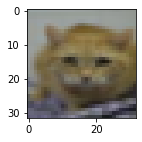

In [ ]:
## Choose 1 image
random_index = random.choice(label_indices)
selected_image = data[random_index]

## Plot
plt.figure(figsize=(2,2))
plt.imshow(selected_image);

**Create a simple CNN with the following structure:**

1. Layer 1 - Convolutional layer with kernel size 3, Stride 1, Output channels 64, Relu activation
2. Maxpool layer with stride 2.
3. Layer 3 - Convolutional layer with kernel size 3, Stride 1, Output channels 64, Relu activation
4. Maxpool layer with stride 2.
4. Layer 4 - Convolutional layer with kernel size 3, Stride 1, Output channels 64, Relu activation
5. Layer 5 - Fully connected layer with 10 outputs

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2,2),stride=2)
        
        self.layer2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d((2,2),stride=2)
        
        self.layer3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        
        ## input 32,32,3
        ## layer 1: 32,32,64
        ## pool1: 16,16,64
        ## layer2: 16,16,64
        ## pool2: 8,8,64
        ## layer3: 8,8,64
        ## input to the linear => 8*8*64 = 4096
        
        self.linear = nn.Linear(4096,10)
        
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()
        

    def forward(self, x):
        ## x: BxCxHxW
        
        x = self.act(self.layer1(x))
        x = self.pool1(x)
        
        x = self.act(self.layer2(x))
        x = self.pool2(x)
        
        x = self.act(self.layer3(x))
        
        x = self.flatten(x)
        x = self.linear(x)

        return x

net = Net()
print(net)

Net(
  (layer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear): Linear(in_features=4096, out_features=10, bias=True)
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


**Training Module**
Training pipeline consists of three key steps:

1. Compute the loss
2. Compute the gradients.
3. Update the weights.

We also set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging.

In [ ]:
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    
    epochs=5
    batch=100
    learning_rate=1e-3
    optimizer = optim.Adam(to_train,lr=learning_rate)
    optimizer.zero_grad()

    for k in tqdm(range(epochs)):
        for l in tqdm(range(int(len(tdata)/batch))):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = torch.FloatTensor(tdata[inds])
            inputs.requires_grad_()
            targets = torch.LongTensor(tlabel[inds])
            
            out = net(inputs) ## compute the outputs.
            loss = criterion(out, targets) ## compute the loss
            loss.backward() ## compute the gradients
            optimizer.step() ## updates the weights.
            optimizer.zero_grad() ## clears the cache/clears the internal states.

            losslist.append(loss.item())
            
            if l > 200:
                break


    return losslist

**Visualize the loss patterns**

We plot the loss pattern (also called convergence pattern or convergence graph) using `losslist`.

In [ ]:
data = torch.permute(torch.Tensor(data), (0,3,1,2))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

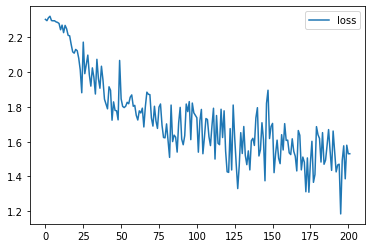

In [ ]:
net = Net()
## transform the labels from cardinal to ordinal.
loss1 = train(data, labels, net, net.parameters())
ax=range(len(loss1))
plt.plot(ax, loss1, label='loss')
plt.legend()
plt.show()